In [17]:
from sklearn.model_selection import GridSearchCV
from genetic import *
import matplotlib.pyplot as plt
import  pandas as pd
#from accountAna import getReportFromCapital
from sklearn.preprocessing import StandardScaler
import copy
#from getDataFromDB import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import empyrical

In [18]:
data = pd.read_csv("E:\\fall 2021\\ML\\TSLA (1).csv")
data["index"] = "TSLA"
data.index = pd.to_datetime(data["Date"])
data["close"] = data["Adj Close"]
data = data.drop(["Date"], axis=1)
data

,Open,High,Low,Close,Adj Close,Volume,index,close
Date,,,,,,,,
2020-03-31,100.250000,108.592003,99.400002,104.800003,104.800003,88857500,TSLA,104.800003
2020-04-01,100.800003,102.790001,95.019997,96.311996,96.311996,66766000,TSLA,96.311996
2020-04-02,96.206001,98.851997,89.279999,90.893997,90.893997,99292000,TSLA,90.893997
2020-04-03,101.900002,103.098000,93.678001,96.001999,96.001999,112810500,TSLA,96.001999
2020-04-06,102.239998,104.199997,99.592003,103.248001,103.248001,74509000,TSLA,103.248001
...,...,...,...,...,...,...,...,...
2021-11-17,1063.510010,1119.640015,1055.500000,1089.010010,1089.010010,31445400,TSLA,1089.010010
2021-11-18,1106.550049,1112.000000,1075.020020,1096.380005,1096.380005,20898900,TSLA,1096.380005
2021-11-19,1098.869995,1138.719971,1092.699951,1137.060059,1137.060059,21168000,TSLA,1137.060059


In [19]:
data["return_2_1"] = data["close"]. shift(-2) / data["close"]. shift(-1)  - 1
data["label"] = data["return_2_1"].apply(lambda x: 1 if x > 0 else 0)
rest_data = data.dropna()
X = rest_data.drop(["return_2_1", "label"], axis=1)
X

,Open,High,Low,Close,Adj Close,Volume,index,close
Date,,,,,,,,
2020-03-31,100.250000,108.592003,99.400002,104.800003,104.800003,88857500,TSLA,104.800003
2020-04-01,100.800003,102.790001,95.019997,96.311996,96.311996,66766000,TSLA,96.311996
2020-04-02,96.206001,98.851997,89.279999,90.893997,90.893997,99292000,TSLA,90.893997
2020-04-03,101.900002,103.098000,93.678001,96.001999,96.001999,112810500,TSLA,96.001999
2020-04-06,102.239998,104.199997,99.592003,103.248001,103.248001,74509000,TSLA,103.248001
...,...,...,...,...,...,...,...,...
2021-11-15,1017.630005,1031.979980,978.599976,1013.390015,1013.390015,34775600,TSLA,1013.390015
2021-11-16,1003.309998,1057.199951,1002.179993,1054.729980,1054.729980,26542400,TSLA,1054.729980
2021-11-17,1063.510010,1119.640015,1055.500000,1089.010010,1089.010010,31445400,TSLA,1089.010010


In [20]:
def backTest(capital, num, tt, commission, action, lev, params, immediate=True):
    '''
    假设 t收盘价 获得信息， 然后给出position 第二天t+1 收盘价来调仓
    所以第t天 现生成new positions， 然后第二天收盘时再判断能否成功。 用已有position 成close 加 cash和 new positon 乘close 相比
    如成功 则减去那些多余的部分 扣cash
    :param tt:  一个df  index 是datetime 或者是sequence index是股票代码  close high low open volume
    :param capital:  初始金额
    :param num:  调仓周期
    :param tt:  个df  index 是datetime 或者是sequence index是股票代码  close high low open volume
    :param commission:
    :param action:   调仓函数 输入为 todayData, position, commission, capital, sequence, params 输出新的position
    :param lev: 可以用的杠杆
    :param immediate 是否第一天就执行逻辑建仓
    :param params: 用于穿个action 函数的额外参数

    :return:  一个df 时间 和 组合金额
    '''

    position = [0 for i in range(len(set(tt["index"])))]  #有正有负
    newPosition = [0 for i in range(len(set(tt["index"])))]
    lastClose = [0 for i in range(len(set(tt["index"])))]
    # print(len(position))
    if immediate:
        Count_refresh_rate = 1
    else:
        Count_refresh_rate = num
    pnl = 0
    history = []
    positions = [] #输出每人positon
    try:
        timeList =  pd.Series(list(set(tt.index))).sort_values()
    except:
        timeList = set(tt.index)
    #每一次
    for sequence in timeList:
        print(sequence)
        #以今天的收盘价更新pnl
        if len(position) == 1:  # 如果只有一个
            todayClose = np.array([tt.loc[sequence,"close"]])
        else:
            todayClose  = tt.loc[sequence,"close"].values
        # print(len(todayClose), todayClose)
        todayPnl = np.dot(position, (todayClose - lastClose))
        pnl += todayPnl
        lastClose = todayClose
        history.append({"time": sequence, "capital": capital + pnl})
        positions.append(position)
        
        #撮合昨天的交易 如果有调仓
        # print(newPosition)
        # print(type(newPosition), type(position),newPosition != position)
        if (newPosition != position):
        # if (newPosition != position).any():
        #money we have
            haveCapital = capital + pnl
            print("capital", capital, "pnl", pnl, "haveCapital", haveCapital)
            print("position", newPosition, "close price", tt.loc[sequence, "close"])
        # money we need
        #     try:
        #         newPortfolio = np.dot(abs(np.array(newPosition)),  tt.loc[sequence,"close"].values)
        #     except Exception as e:
        #         print(newPosition)
            if len(position) == 1: 
                newPortfolio = np.dot(abs(np.array(newPosition)), np.array(tt.loc[sequence, "close"]))
            else:
                newPortfolio = np.dot(abs(np.array(newPosition)), tt.loc[sequence, "close"].values)
            position_change = np.array(newPosition) - np.array(position)
            
            if len(position) == 1:
                commission_cal_money = np.dot(abs(np.array(position_change)), np.array([tt.loc[sequence, "close"]]))
            else:
                commission_cal_money = np.dot(abs(np.array(position_change)), tt.loc[sequence, "close"].values)
            commission_expense = commission_cal_money * commission
            needCapital = newPortfolio + commission_expense
        #judge
            if haveCapital * lev >= needCapital:
                print("success position change")
                # comission
                capital -= commission_expense
                position = newPosition
            else:
                print(haveCapital * lev, needCapital)
                print(newPosition)
                print(tt.loc[sequence, "close"])
                print("not enough capital")

    # 不在调仓周期 ，不会触发策略逻辑
        if Count_refresh_rate - 1 != 0:
            Count_refresh_rate -= 1
        else:
            Count_refresh_rate = num
            # print("change_position")
            # change position
            newPosition = action(tt[tt.index <= sequence], copy.deepcopy(position), commission, capital + pnl, sequence, params)
            # print(len(newPosition))
            # print(newPosition)

    return  pd.DataFrame(history), positions


In [21]:
def evaluate_model(params, X_train, X_test, y_train, y_rate):
    ''' params  {"PCA":{"C":2}}'''
    print(params)
    clf = make_pipeline(
            StandardScaler(),
            #SelectKBest(k='all'),
            PCA(**params["PCA"]), 
            # LogisticRegression(C=c)
            SVC(**params["SVC"])
            # RandomForestClassifier(max_depth=c)
            
        )
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    # prediction = clf.predict_proba(X_test)

    print(prediction)
    score = classification_backtest(y_rate, prediction)    
    return score, clf


In [22]:
def get_train_test(X, y, split_index):
    ''' 根据split index 返回切分'''
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]
    return X_train, y_train, X_test, y_test

In [23]:
def train_model(have_data, model_name, population_candidate=[]):
    # 有足够data train
    have_data["return_2_1"] = have_data["close"]. shift(-2) / have_data["close"]. shift(-1)  - 1
    have_data["label"] = have_data["return_2_1"].apply(lambda x: 1 if x > 0 else 0)
    rest_data = have_data.dropna()
    X = rest_data.drop(["return_2_1", "label"], axis=1)
    y = rest_data["label"]
    # X_train, y_train = X,y
    test_partial = 0.4
    split_index = int(len(X)* (1 - test_partial))
    X_train, y_train, X_test, y_test = get_train_test(X, y, split_index)   


    x = genetic_model(X_train, X_test, y_train, rest_data["return_2_1"][split_index:],\
                      model_name, population_size=50, mutation_rate=0.89, crossover_rate=0.1,\
                     elitism=0.01, generations=100, early_stop=2, population_candidate=population_candidate)
    x.run()
    return x
    
    
    # pca components int 类型 需要调整 
    # lg, svc c 需要调整 0-1 float
    param_grid = {"n_components":[2,4,6], "C":[0.1, 0.3, 0.9]}
    max_score = -100000
    for c in [0.1, 0.3, 0.9]:
    # for c in [1, 2, 4, 6]:

        # # clf
        # clf = make_pipeline(
        #     StandardScaler(),
        #     #SelectKBest(k='all'),
        #     PCA(), 
        #     # LogisticRegression(C=c)
        #     # SVC(C=c)
        #     # RandomForestClassifier(max_depth=c)
            
        # )
        # clf.fit(X_train, y_train)
        # prediction = clf.predict(X_test)
        # # prediction = clf.predict_proba(X_test)

        # print(prediction)
        # score = classification_backtest(rest_data["return_2_1"][split_index:], prediction)
        # # score = classification_backtest_prob(rest_data["return_2_1"][split_index:], prediction)
        
        score, clf = evaluate_model({"PCA":{"n_components":2},"SVC":{"C":c}}, X_train, X_test, y_train, rest_data["return_2_1"][split_index:])

        if score > max_score:
            max_score = score
            best_clf = clf
            print("best_c", c)
    # clf = GridSearchCV(clf, param_grid, scoring, cv=5).fit(X_train, y_train)
    # print(clf.best_params_)
    # print(clf.best_score_)
    # clf.fit(X_train, y_train)
    # clf.score(X_train, y_train)
    # clf.predict(X_train)
    return best_clf


In [24]:
def getTradingLastPerDay(x):
    return x.iloc[-1]

In [25]:
def getReportFromCapital(df, rf):
    '''
    the data after using backtst from /client/a
    Parameters
    ----------
    df  : time capital

    Returns
    -------
    reprot
    '''
    report = {}
    df["simpleReturn"] = df["capital"] / df["capital"].shift(1) - 1
    df["cum"] = empyrical.cum_returns(df["simpleReturn"])
    df["cumulative_values"] = df["cum"] + 1

    # daily data used to calcualte annual data ?? 那个时间段怎么回事
    daily = copy.deepcopy(df)
    daily["Time"] = daily["time"].apply(lambda x: x.date())
    daily = daily.groupby("Time").apply(getTradingLastPerDay)
    daily["nextReturn"] = daily["cumulative_values"].shift(-1) / daily["cumulative_values"] - 1

    # return a dict
    report['区间净值'] = round(empyrical.cum_returns_final(df["simpleReturn"]) + 1, 3)
    report['最大回撤'] = round(empyrical.max_drawdown(df["simpleReturn"]), 4)
    report['年化收益率'] = empyrical.annual_return(daily["nextReturn"], annualization=365)
    report['年化波动率'] = round(empyrical.annual_volatility(daily["nextReturn"], annualization=365), 3)
    report['风险波动比'] = round(empyrical.sharpe_ratio(daily["nextReturn"], annualization=365, risk_free=rf / 365), 3)
    return pd.Series(report), daily

In [26]:
def logit(have_data, position, commission, all_capital, sequence, model_name):
    ''' 每4天买卖一次'''
    global model, population_candidate, negative
    if len(have_data) < 250:
        return position
    have_data = have_data.drop(["index"], axis=1)

    population_candidate = []
    if len(have_data) >= 250:
        if len(have_data) % 10 == 0:
            result = train_model(have_data, model_name, population_candidate)
            model = result.best_clf
            population_candidate = result.population
            if result.highest_score < 0:
                print(sequence)
              
        # 0[0.62036022 0.37963978] predict here
                
        if not model:
            return [100]
        last_data = have_data.iloc[-1]
        try:
            last_data = last_data.drop(["return_2_1", "label"])
        except KeyError:
            print(last_data)

            pass
        prediction = model.predict(np.array(last_data).reshape(1, -1))[0]  
        # prediction = model.predict_proba(np.array(last_data).reshape(1, -1))[0][1]
        print(model.predict(np.array(last_data).reshape(1, -1)) )           
        # print(model.decision_function(np.array(last_data).reshape(1, -1))   )      
        # decision_score = model.decision_function(np.array(last_data).reshape(1, -1))[0]     
        # prediction = max(decision_score, 0)
        print(prediction, "predict here")
        return [prediction * 100]


In [27]:
def evaluation(backtest_data, positions):

    positions = pd.DataFrame(positions)
    join_data = backtest_data.join(positions)
    join_data["future_delta"] = join_data[0] - join_data[0].shift(-1)

    every_trade = join_data[join_data["future_delta"] != 0]
    every_trade_indexs = every_trade.index

    plt.title("decay")
    for i in range(0, len(every_trade_indexs) // 2 * 2, 2):
        cur_data = join_data.loc[every_trade_indexs[i]: every_trade_indexs[i+1]]
        cur_data["pnl"] = cur_data["capital"] - cur_data["capital"].iloc[0]
        # time_start = cur_data["time"].iloc[0]
        # cur_data["time_delta"] = cur_data["time"] - time_start
        cur_data_indexs = cur_data.index
        plt.plot(cur_data_indexs - cur_data_indexs[0], cur_data["pnl"])
        
    report,daily = getReportFromCapital(backtest_data, 0.06)
    print(report)

In [28]:
def hold(have_data, position, commission, all_capital, sequence, params):
    ''' 每4天买卖一次'''

    return [100]

In [29]:
def buy_and_sell_every_four_day(have_data, position, commission, all_capital, sequence, params):
    ''' 每4天买卖一次'''
    if len(have_data) % 4 == 0:
        position[0] = 100 - position[0]
    return position

In [30]:
capital = 100000
num = 1
commission = 0
lev = 1
params = 0

backtest_data, positions = backTest(capital, num, data, commission, logit, lev, 'SVC', immediate=True)

2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
2020-04-27 00:00:00
2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00
2020-05-01 00:00:00
2020-05-04 00:00:00
2020-05-05 00:00:00
2020-05-06 00:00:00
2020-05-07 00:00:00
2020-05-08 00:00:00
2020-05-11 00:00:00
2020-05-12 00:00:00
2020-05-13 00:00:00
2020-05-14 00:00:00
2020-05-15 00:00:00
2020-05-18 00:00:00
2020-05-19 00:00:00
2020-05-20 00:00:00
2020-05-21 00:00:00
2020-05-22 00:00:00
2020-05-26 00:00:00
2020-05-27 00:00:00
2020-05-28 00:00:00
2020-05-29 00:00:00
2020-06-01 00:00:00
2020-06-02 00:00:00
2020-06-03 00:00:00
2020-06-04 00:00:00
2020-06-05 00:00:00
2020-06-08 00:00:00
2020-06-09 00:00:00
2020-06-10 00:00:00


0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
32
33
34
35
36
37
38
39
40
41
42
43
44
45
47
48
49
50
2 generation
0.36566796700093507
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.5620800753

0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.3259391407958864
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.3259391407958864
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.3259391407958864
0.56208007534907 highest
0.3259391407958864
0.56208007534907 highest
0.3259391407958864
0.56208

0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.29425946414818316
0.56208007534907 highest
0.29425946414818316
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.29425946414818316
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.29425946414818316
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.29425946414818316
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.29425946414818316
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907

0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.36566796700093507
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.36566796700093507
0.56208007534907 highest
0.36566796700093507
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.36566796700093507
0.56208007534907 highest
0.36566796700093507
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.

0.56208007534907
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.029433010849649333
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.20117256503625314
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.27315270738867126
0.56208007534907 highest
0.56208007534907
0.56208007534907 highest
0.2

0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
28
29
31
33
34
35
37
38
39
40
41
42
43
45
46
47
48
49
50
2 generation
0.26960732682278854
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.31835965889614515
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.48009015189191395
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.14564972600049952
0.60728702685

0.6072870268565439
0.6072870268565439 highest
0.05618259865862396
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.05618259865862396
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
1
2
3
4
5
7
8
9
10
11
12
13
14
1

0.21115760477478562
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.31835965889614515
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.31835965889614515
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.20087359679583516
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.20087359679583516
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.31835965889614515
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.20087359679583516
0.6072870268565439 highest
0.6072870268565439
0.607287

0.6072870268565439
0.6072870268565439 highest
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
27
28
29
30
31
32
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
13 generation
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.4176461473193147
0.6072870268565439 highest
0.6072870268565439
0.607287

0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
1
2
3
4
5
6
8
10
11
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
32
33
34
35
36
38
39
40
41
43
44
45
46
47
48
49
50
51
1

-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
0.6072870268565439
0.6072870268565439 highest
-0.011140936282527436
0.6072870268565439 highest
-0.011140936282527436
0.60728702

0.37114609230336026
0.6072870268565439 highest
0.2556319727363927
0.6072870268565439 highest
0.37114609230336026
0.6072870268565439 highest
0.37114609230336026
0.6072870268565439 highest
0.37114609230336026
0.6072870268565439 highest
0.2556319727363927
0.6072870268565439 highest
0.37114609230336026
0.6072870268565439 highest
1
2
3
4
5
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
no update after2
[1]
1 predict here
2021-04-13 00:00:00
[1]
1 predict here
2021-04-14 00:00:00
[1]
1 predict here
2021-04-15 00:00:00
[1]
1 predict here
2021-04-16 00:00:00
[1]
1 predict here
2021-04-19 00:00:00
[1]
1 predict here
2021-04-20 00:00:00
[1]
1 predict here
2021-04-21 00:00:00
[1]
1 predict here
2021-04-22 00:00:00
[1]
1 predict here
2021-04-23 00:00:00
[1]
1 predict here
2021-04-26 00:00:00
0 generation
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823


0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.3535303005315542
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.4111835667607613
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726

0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
1
2
3
4
6
7
8
9
10
12
13
14
15
17
18
19
20
21
22
23
24
25
26
28
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
7 generation
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.61288704557

0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.4111835667607613
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.4111835667607613
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.4111835667607613
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726

0.20647361551197352
0.6128870455726823 highest
0.20647361551197352
0.6128870455726823 highest
0.20647361551197352
0.6128870455726823 highest
0.20647361551197352
0.6128870455726823 highest
1
2
3
4
5
6
8
9
10
11
12
14
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
43
44
45
46
47
48
49
50
51
52
14 generation
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.0584361651080878
0.6128870455726823 highest
0.0584361651080878
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.0584361651080878
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.0584361651080878

0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726

0.6128870455726823
0.6128870455726823 highest
0.304611420731576
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.304611420731576
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.304611420731576
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.304611420731576
0.6128870455726823 highest
1
2
3
4
5
6
7
9
10
11
12
13
14
15
16
1

0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726

0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
22
23
24
25
27
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
45
46
47
49
50
51
53
28 generation
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.6128870455726823 highest
0.6128870455726823
0.61288704

0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726823 highest
0.0922830263026998
0.6128870455726

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
4
5
6
7
8
9
10
12
13
14
15
16


0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
9
11
12
13
14
15
17
19
20
21
22
23
24
25
26
27
28
29
30
31
33
34
35
36
37
38
39
40
41
42
43
45
47
49
50
10 gen

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
34
35
36
37
38
40
41
42
43
44
45
46
47
48
49
50
24 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.18634

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
28 generation
0.1863440295151667


0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
38 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.186344029515166

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
15
16
17
19
20
21
23
24
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
50
51
45 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.18634402

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
3

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
3
4
5
6
8
9
10
12
13
14
15
17
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
41
42
43
44
45
46
47
48
49
50
51
59 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.186344029515

0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.18634

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
45
46
48
49
50
52
66 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
9
11
12
13
14
16
18
19
20
21
22
23
24
25
26
27
28
30
31
32
33
34
35
36
37
38
39
41
42
43
44
46
47
48
49
51
52
73 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.18634402951

0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.18634

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
20
21
22
23
24
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
48
49
50
51
53
80 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
87 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151

0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
97 generation
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.1863440295151667
0.1863440295151667 highest
0.186344

0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 

0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 

0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
-0.08728323053831255
0.10912887780982239 highest
0.10912887780982239
0.10912887

0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
1
2
3
4
5
6
8
9
10
11
12
13
14
15
16
17
19
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
43
44
45
46
47
48
49
50
52
11 generation
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.109128877809822

0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 

0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
1
2
4
5
6
7
8
9
10
11
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
41
42
43
44
45
47
48
49
50
52
18 generation
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 

0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 highest
0.10912887780982239
0.10912887780982239 

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
1
3
4
5
6
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
4 generation
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 

-0.16164144624152432
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
19
20
21
22
23
24
25
26
28
30
31
32
33
34
35


0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
29
30
31
32
33
35
36
37
38
39
40
41
43
44
45
46
47
48
49
50
51
14 generation
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.034770662106610

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 

0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17


0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
1
2
4
5
6
7
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
52
31 generation
0.03477066210661062
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
0.03477066210661062
0.03477066210661062 highest
-0.16164144624152432
0.034770662

-0.16164144624152432
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
-0.16164144624152432
0.03477066210661062 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
24
25
26
27
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
44
45
46
47
48
49
50
52
no update after2
[1]
1 predict here
2021-06-09 00:00:00
[1]
1 predict here
2021-06-10 00:00:00
[1]
1 predict here
2021-06-11 00:00:00
[1]
1 predict here
2021-06-14 00:00:00
[1]
1 predict here
2021-06-15 00:00:00
[1]
1 predict here
2021-06-16 00:00:00
[1]
1 predict here
2021-06-17 00:00:00
[1]
1 predict here
2021-06-18 00:00:00
[1]
1 predict here
2021-06-21 00:00:00
[1]
1 predict here
2021-06-22 00:00:00
0 generation
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.0622

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
-0.134184703274559
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
-0.134184703274559
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
-0.134184703274559
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 hig

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
-0.134184703274559
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
-0.134184703274559
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
-0.134184703274559
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 hig

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
31
32
33
34


0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
26
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
44
45
46
47
48
49
50
51
21 generation
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.0622274050735

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 

0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
15
16
17
18
20
21
22
23
24
25
26
27
29
30
31
32
33
35
36
37
38
40
41
42
43
44
45
46
47
48
49
50
51
28 generation
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 highest
0.06222740507357594
0.06222740507357594 h

-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 

-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 

-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 highest
-0.00019386607811400225
-0.00019386607811400225 

-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 highest
-0.19660597442624894
-0.00019386607811400225 h

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
22
23
24
25
27
28
29
30
31
32
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
50
52
9 generation
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
1
3
4
5
6
7
8
9
11
12
13
14
15
17
19
20
21
22
23
24
26
27
28
29
30
31
32
33
34
35
36
37


-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 

-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
-0.1313749651861632
-0.1313749651861632 highest
1
2
3
4
5
6
8
10
11
12
13
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
40
41
42
43
44
45
47
48
49
50
51
52
54
35 generation
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1313749651861632 highest
-0.32778707353429815
-0.1

-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
1
2
4
5
6
7
8
9
10
11
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
37
38
39
40
41
43
44
45
46
47
48
49
50
51
2 generation
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.0

-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest


-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
30 generation
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874

-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
16
17
18
19
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
50
51
52
53
33 generation
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highes

-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
1
2
3
4
5
6
7
8
10
12
13
14
15
16
17
18
19
20
21
22
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
47
48
49
50
51
52
53
54
36 generation
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highest
-0.09661117031198874
-0.09661117031198874 highe

-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest


-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184


-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
1
3
4
6
8
9
10
11
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
52
7 generation
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901

-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest


-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest


-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
37
38
40
41
42
43
44
45
46
47
48
49
50
51
52
17 generation
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 hig

-0.10901045878886184
-0.10901045878886184 highest
1
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
30
31
32
33
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
20 generation
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest


-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest


-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest


-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
-0.10901045878886184
-0.10901045878886184 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
25
26
28
29
31
32
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
52
30 generation
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.3054225671369968
-0.10901045878886184 highest
-0.30542256713

-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 

-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 highest
-0.0678169512699397
-0.0678169512699397 

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
30
31
33
34
35
37
38
39
40
41
42
44
45
46
47
48
49
51
2 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
2
3
4
5
6
7
9
11
12
13
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
40
41
42
43
44
45
46
47
48
49
50
51
5 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.0296

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
24
25
26
27
28
29
30
31
32
33
35
36
38
39
40
41
42
44
45
47
48
49
50
51
15 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.02969

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
1
3
4
5
6
7
8
9
11
12
13
14
15
17
18
19
20
21
22
23
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
18 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.0296

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
1
2
4
5
7
9
11
12
13
14
16
17
18
19
20
21
22
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
40
41
42
43
44
45
46
48
50
51
31 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.02969581626286

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
1
2
3
4
5
6
8
9
10
11
12
14
15
16
17
18
19
20
21
23
24
26
27
28
29
30
31
32
33
34
35
37
39
40
41
42
43
44
45
46
47
48
49
50
51
34 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.0296958

0.029695816262865438
0.029695816262865438 highest
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
49
50
52
37 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


0.029695816262865438
0.029695816262865438 highest
1
2
3
5
6
7
8
9
11
12
13
14
15
16
17
18
19
20
21
22
24
25
26
27
28
30
31
33
34
35
37
38
39
41
42
43
44
45
46
47
48
49
51
53
40 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
-0.16671629208526

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
44
45
46
47
48
50
51
52
53
43 generation
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 hig

0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest
0.029695816262865438
0.029695816262865438 highest


-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695
0.029695816262865438 highest
-0.1667162920852695


0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
5
6
7
8
9
10
11
13
15
16
17
18
19
20
22
23
24
25
26
27
28
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51
6 generation
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highe

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
6
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
13 generation
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
5
6
7
8
9
10
12
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
45
46
47
48
49
50
51
20 g

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
43
44
45
46
47
48
49
50
51
52
53
30 generation
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.120044

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
3

0.12004405749459279
0.12004405749459279 highest
1
2
3
5
7
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
33
34
35
36
37
38
39
41
42
43
44
45
46
47
48
49
50
51
52
53
40 generation
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.1200440574

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
34
35
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
47 generation
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.1200440

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
20
21
22
23
24
26
27
28
29
30
31
33
34
35
36
37
39
40
41
42
43
44
45
46
47
48
49
50
51
53
57 generation
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.1200440574945

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 

0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
0.12004405749459279
0.12004405749459279 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1

0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
45
46
47
48
49
51
1 generation
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.34270747322786

0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227

0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.3271286235452844
0.

0.342707473227865
0.342707473227865 highest
0.3360549808075175
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
1
2
3
4
5
6
8
9
10
12
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
33
35
36
37
38
39
40
41
42
43
44
45
46
47
48
50
51
12 generation
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.34270

0.2909375531440198
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.2909375531440198
0.342707473227865 highest
0.2909375531440198
0

0.11984928894051372
0.342707473227865 highest
0.11984928894051372
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.11984928894051372
0.342707473227865 highest
0.11984928894051372
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
29
30
31
32
33
35
36
37
38
39
41
42
43
44
45
46
48
49
51
19 generation
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.34270747322

0.342707473227865
0.342707473227865 highest
0.09486073262626826
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.09486073262626826
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.09486073262626826
0.342707473227865 highest
0.09486073262626826
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.09486073262626826
0.34

0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227

0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.299077253146666
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.299077253146666
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.299077253146666
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
0.342707473227865
0.342707473227865 highest
1
2
3
4
5
6
7
8
9
10
12
13
15
16
17
18
19
20
21
22
23
24
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
30 generation
0.342707473227865
0.342707473227865 highest
0.3427074732278

0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
1
2
3
4
5
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
1 generation
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.4965766282721341 highest
0.4965766282721341
0.49657662

0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.45274045928944273
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.4965766282721341
0.5028506482300897 highest
0.45274045928944273
0.5028506482300897 highest
0.4965766282721341
0.50285064823

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
1
2
3
4
5
6
7
8
9
11
12
13
14
16
1

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
10 generation
0.4443253888590114
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.529235591731542

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.4443253888590114
0.5292355917315429 highest
0.4443253888590114
0.5292355917315429 highest
0.4443253888590114
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4443253888590114
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4443253888590114
0.5292355917315429 highest
0.4443253888590114
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4443253888590114
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4443253888590114
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
1
2
3
4
5
6
7
8
9
10
11
13
14
15
16
17
19
20
21
22
23
24
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
20 generation
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.52

0.4443253888590114
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
1
2
3
4
5
7
8
9
10
11
12
13
14
15
16
18
19
20
21
22
23
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
47
48
49
50
51
52
34 generation
0.5292355917315429
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.23791959535866503
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.4465580932502776
0.

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.3964479043096306
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.3964479043096306
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.3964479043096306
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.3964479043096306
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
1
2
3
4
5
6
7
8
10
11
13
14
15
16
17
18
19
20
21
22
23
24
26
27
28
29
30
31
32
33
34
35
36
37
38
39
41
42
44
45
46
47
48
49
50
51
52
53
41 generation
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315

0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
1
2
3
4
5
6
7
8
10
11
13
14
15
16


0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.39388634963164537
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.39388634963164537
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.39388634963164537
0.5292355917315429 highest
0.39388634963164537
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.39388634963164537
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
2
3
4
5
6
7
9
10
11
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
29
30
31
33
34
36
37
38
40
41
42
43
44
45
46
47
49
51
52
53
54
56
54 generation
0.39388634963164537
0.

0.3573374084602532
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.3573374084602532
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.4465580932502776
0.5292355917315429 highest
0.3573374084602532
0.5292355917315429 highest
1
2
3
4
5
6
7
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
25
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
48
49
50
52
53
54
55
56
57 generation
0.18599961449871216
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.5292355917315429
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.18599961449871216
0.5292355917315429 highest
0.5292

<ipython-input-27-b995c3b8f92c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_data["pnl"] = cur_data["capital"] - cur_data["capital"].iloc[0]
<ipython-input-27-b995c3b8f92c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_data["pnl"] = cur_data["capital"] - cur_data["capital"].iloc[0]
<ipython-input-27-b995c3b8f92c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

区间净值     1.191000
最大回撤    -0.172800
年化收益率    0.164715
年化波动率    0.226000
风险波动比    0.525000
dtype: float64


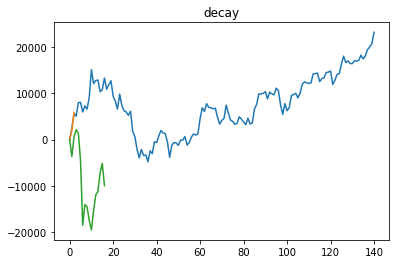

In [31]:
evaluation(backtest_data, positions)